In [1]:
# AUTHOR: Torben Guijarro, CID:01984901

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
# %% Load dataset

datadir = 'cw3_data/dataset3_m62/'
trackdata = io.loadmat(datadir+'downTrackdata.mat')
phi = trackdata['phi']; x = trackdata['x']; y = trackdata['y']; r=trackdata['r'];
speed = trackdata['speed']; t = trackdata['time'];
spikedata = io.loadmat(datadir+'spikes.mat')
spikes = spikedata['spikes']
params = spikedata['params']
fluodata = io.loadmat(datadir+'fissa_output.mat')
dFonF = fluodata['ddf_f'] # fluorescence time-series variable
C = np.size(dFonF,0) # number of cells
fs = 30.92 # sampling rate in Hz - everything is resampled at this rate
L = np.size(dFonF,1)
t = np.linspace(0,L*1/fs,L) # duration of recording in sec

## Question 1 [30 marks]

You may have noticed that the calcium fluorescence time series for each cell in this dataset
comprises brief “calcium transient” events interspersed amongst the baseline fluorescence. Write a
function to convert each time series into an event train, in which an (instantaneous) event
corresponds to the beginning of a detected calcium transient. Your detection code might be as
simple as threshold crossing, or it might be more complex. This event train should be a binary
process (i.e. “1” where there is an event, “0” otherwise). Given that the calcium transients have a
rapid rise followed by a slow decay, you should have one event per calcium transient at the rise
time, rather than the event train remaining at “1” for the whole calcium transient pulse.

For the first three cells, plot the continuous fluorescence time series as a function of time, with the
times of detected events marked by a tick over or under-laid on the same plot.

In [3]:
# Method 1
def eventtrain_fct(dfonf,threshold):
    eventtrain = np.zeros(dfonf.shape, dtype=np.int64)
    
    for i in range(dfonf.shape[0]): # for each cell
        anterior = dfonf[i][0]
        if dfonf[i][0] >= threshold: #for the first value
             eventtrain[i][0] = 1
        for j in range(1, dfonf.shape[1]): # for each time
            if dfonf[i][j] >= threshold and anterior < threshold:
                eventtrain[i][j] = 1
                #print(i, j)       
            anterior = dfonf[i][j]
            
    return eventtrain

In [9]:
# Method 2
def eventtrain_fct(dfonf, threshold):
    eventtrain = np.zeros(dfonf.shape, dtype=np.int64)
    
    WAY = False
    for i in range(dfonf.shape[0]): # for each cell
         for j in range(dfonf.shape[1]): # for each time
            if dfonf[i][j] > threshold:
                 if not(WAY):
                    eventtrain[i][j] = 1
                    WAY = True
                    continue
            else:
                WAY = False
                     
    return eventtrain
    
# Apply function, using a threshold of 7.
train = eventtrain_fct(dFonF,7)

Diagram for Method 2:

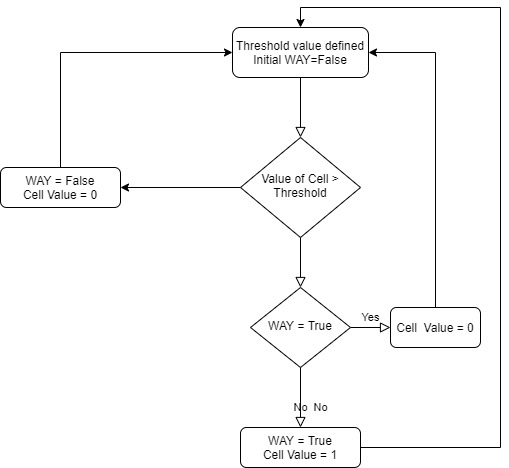

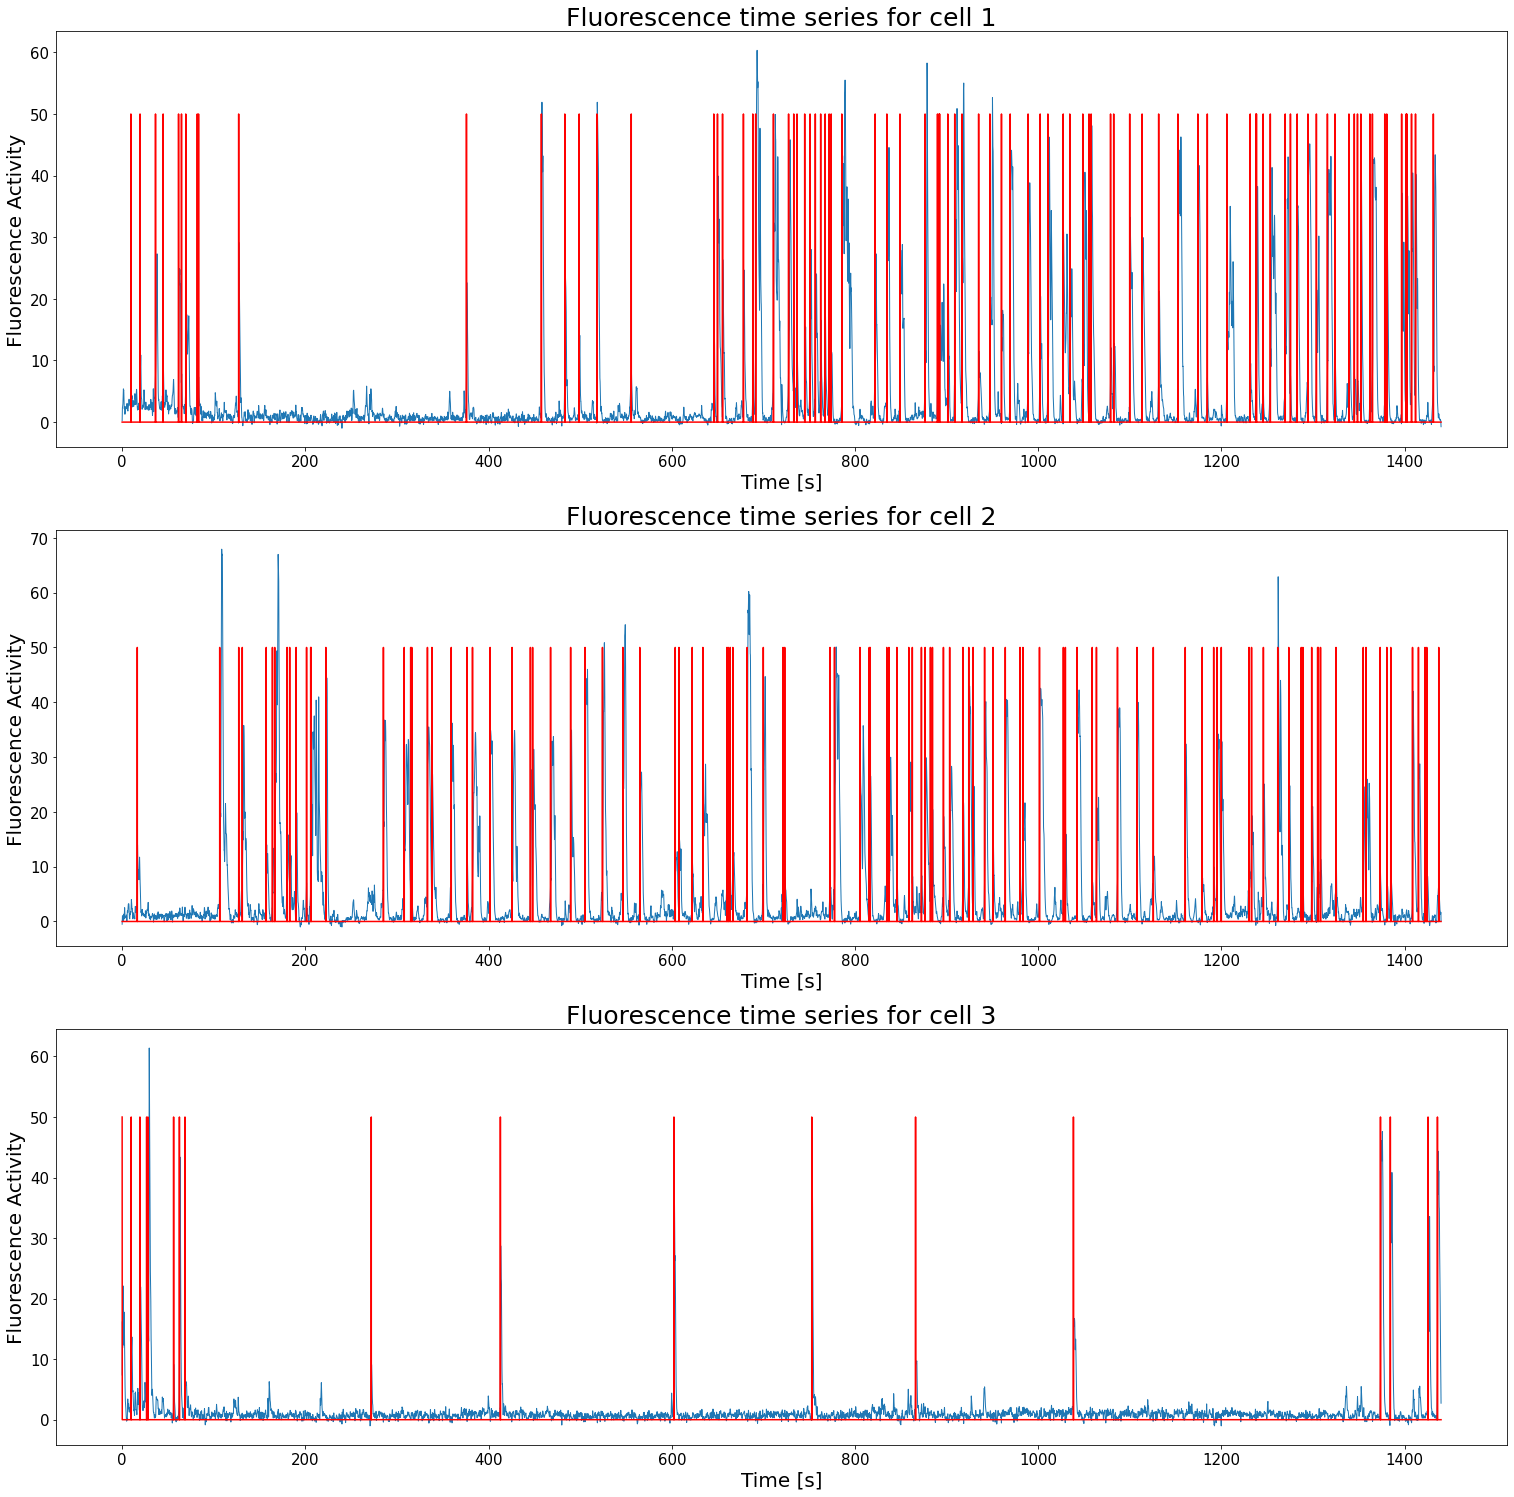

In [10]:
# Adapting binary values for plot
ntrain = train.astype(np.float64)
#ntrain[train == 0] = np.nan 
ntrain[train == 1] = 50 # Amplifying the signal so it is visible on the plots
ntrain

# Plotting Fluorescence time series
plt.figure(1,figsize=(26,26))
plt.clf()
#plt.plot(t, ntrain[1,:])

plt.subplot(3,1,1)
plt.plot(t,dFonF[0,:],linewidth=1) 
plt.plot(t, ntrain[0,:],'r')
plt.title('Fluorescence time series for cell 1',fontsize=25)
plt.ylabel('Fluorescence Activity',fontsize=20) 
plt.xlabel('Time [s]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplots_adjust(hspace=0.2)

plt.subplot(3,1,2)
plt.plot(t,dFonF[1,:],linewidth=1)
plt.plot(t, ntrain[1,:],'r')
plt.title('Fluorescence time series for cell 2',fontsize=25)
plt.xlabel('Time [s]',fontsize=20)  
plt.ylabel('Fluorescence Activity',fontsize=20)  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplots_adjust(hspace=0.2)

plt.subplot(3,1,3)
plt.plot(t,dFonF[2,:],linewidth=1)
plt.plot(t, ntrain[2,:],'r')
plt.title('Fluorescence time series for cell 3',fontsize=25)
plt.xlabel('Time [s]',fontsize=20)  
plt.ylabel('Fluorescence Activity',fontsize=20)   
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Question 2 [20 marks]

As described in previous coursework exercises (particularly Coursework One), the data is
collected from a mouse running in repeated loops around a circular track. Write a function which
returns the data for a cell in the form response[trial,position], where trial indicates which loop
around the track the mouse is on, position indicates the binned spatial angle of the mouse’s
location, and response is 0 or 1 as above. Plot this as a `rastergram’ (ticks indicating events on axes
showing trials (y axis) vs angular location (x axis)) for three example cells showing high, medium and
low selectivity of the firing of the cell to the mouse’s location on the circular track. Show this
rastergram for the same three cells (cells 0,1,2).

The binary event train computed in Question 1 was divided into trials (number of loops around the circular track) and ordered into 20 angular bins, i.e. each bin width is 18 degrees, to show the cell activity. By observing large changes ion angular position, we calculated 71 laps (trials) ran by the mouse. Then, the cell responses where plotted into Rastergrams in function of their angular position and trials. From these, we can observe the selectivity of the cells and how  some neurons are more tuned to be activated in some angular positions than others. Also, some are not as influence by the angular position. 

In [11]:
# %% Useful functions provided

# function to break up the fluorescence response of each cell into laps
# takes as input:
# sp: a vector of a cell's activity binarized into 0,1 (spiking/not-spiking) 
# phi_bin: sequence of angular position values, binned into nphi bins
# nlaps: laps
def get_lapresponse(sp,phi_bin,nlaps,nphi):
    response = np.zeros((nlaps,nphi))
    lap=0
    phi0=phi_bin[0]
    lapflag=True  # flag to ensure we only increment lap counter on first time in bin
    for i in range(0,L):
        if  sp[i]:
            response[lap][phi_bin[i]-1] += 1
        # and augment lap counter
        if (phi_bin[i]==phi0 and lapflag==True):
            lap += 1
            lapflag=False # put down flag until we are past this bin
            #print(lap)
        if phi_bin[i]>phi0:
            lapflag=True

    return response, lap

# Number of bins used for discretisation
nbins_phi = 20

# Binning spatial variable phi
edges = np.arange(0,360,360/nbins_phi)
phi_bin = np.digitize(phi,edges)

# To estimate the number of laps we detected big jumps in the angular
# position that seem to be equivalent to a revolution. A change in angular location
# bin greater to 10 is equivalent to at least 180 degree jump.
dphi = np.diff(phi_bin,axis=0)
#plt.plot(t[:-1],dphi,'r-')
nlaps = np.count_nonzero(dphi>10)+2 # a bit of a hack, sorry - but this works  
# print(nlaps)

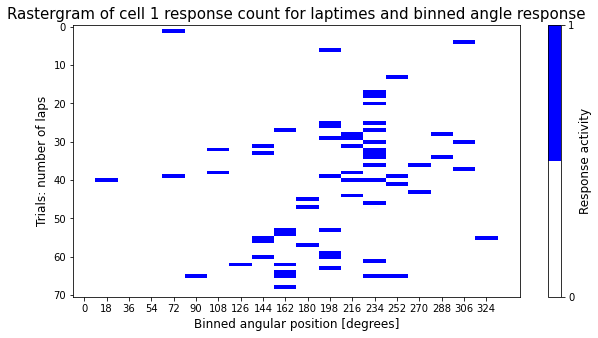

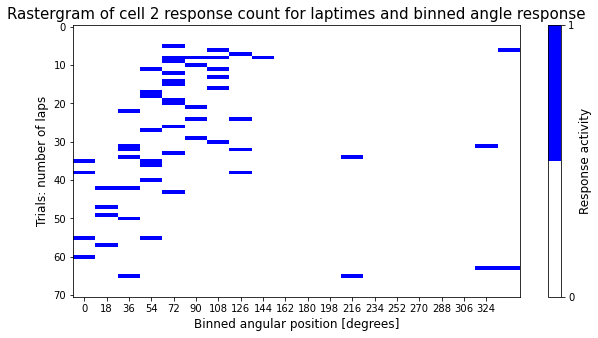

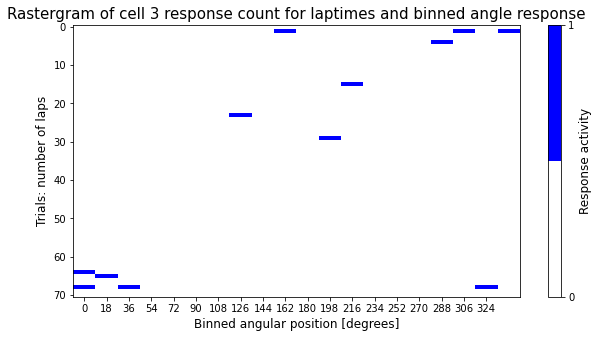

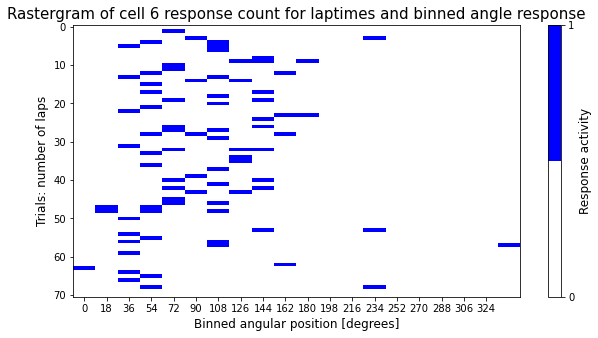

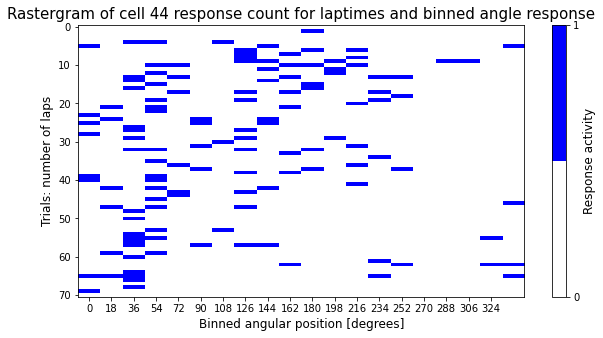

In [12]:
# Creating new train with threshold at 20
train2 = eventtrain_fct(dFonF,20)

#  Function to binarise response
def binarised(resp,thresh):
    binary_response = np.zeros(resp.shape)
    for i in range(resp.shape[0]): # for each row
         for j in range(resp.shape[1]): # for each column
            if resp[i][j] >= thresh:
                binary_response[i][j] = 1
    return binary_response

# Discretising into binary colour map
cmap = ListedColormap(["None", "blue"]) 

# Plots of first three cells
list = [0,1,2,5,43]
for i in list:
    train_cell = train2[i,:]
    response,lap = get_lapresponse(sp=train_cell, phi_bin=phi_bin, nlaps=nlaps, nphi=edges.size)
    bin_resp = binarised(response,1)
    
    plt.figure(1+i, figsize=(10,5))
    plt.imshow(bin_resp,cmap=cmap,aspect='auto')
    plt.title(f'Rastergram of cell {i+1} response count for laptimes and binned angle response', fontsize=15)
    plt.xlabel('Binned angular position [degrees]', fontsize=12)
    plt.ylabel('Trials: number of laps', fontsize=12)
    
    cbar = plt.colorbar(ticks=[0,1])
    cbar.ax.set_yticklabels(['0','1'])
    cbar.ax.set_ylabel('Response activity', fontsize=12)
    ticks = np.arange(0,19)
    ticklabel = ['0','18', '36', '54', '72','90','108','126','144','162','180','198','216', '234','252','270','288','306','324','342','360']
    plt.xticks(np.arange(0,19), labels=ticklabel, fontsize=10)
    plt.yticks(np.arange(0,71,10), fontsize=10)


The matrices present the response of a particular cell at a given angular bin and given trial (circle loop revolution).
From the plots we can observe that cell 3 shows low firing rate (low selectivity), while cells 1 and 2 have similar firing intensities and a medium selectivity. Finally, cells 6 and 44 shows high selectivity. Cells 1 and 2, with medium selectivity present activity in medium range of angles (approximately 126 degrees to 270 degrees for cell 1 and 0 to 126 for cell 2). On the other hand, high selectivity cells like 6 or 44 cover a larger span of degrees (0 to 270 approx. for cell 44). Finally, cell 3, with low selectivity shows only activity at the "ends" of the track (0 and 360 degrees). 
These differences show how cells are tuned for different spatial positions of the mouse. Furthermore, we might be able to observe a small correlation between the trial number getting higher and the angular position of the mouse. As the mouse runs clockwise, and the number of trials increases there is a slight shift in the angular value. This means depending on the activity, the cell will activate later or not. This seems justifiable as neurons change their response when stimulated frequently. 

## Question 3 [30 marks] 

For these 3 cells, calculate the mutual information between the binary response variable and
spatial angle, phi. Use 20 bins for spatial angle. Does this correspond to what you expect based on
the previous plots? Use the “plugin” estimator for mutual information (i.e. direct implementation
using the Shannon formula), and write your own function for estimating mutual information.

In [13]:
def entropy(px):
    idx = px>0
    H = -np.sum(px[idx]*np.log2(px[idx]))
    return H

In [14]:
# Using Shanons entropy formula
def mutual_information(z, phi, N):
    cs,bins = np.histogram(z,N)
    cr,bins = np.histogram(phi,N)
    csr,bins_s,bins_r = np.histogram2d(z,phi.squeeze(),N)
    Ps = cs / cs.sum()
    Pr = cr / cr.sum()
    Psr = csr / csr.sum()
    Hs = entropy(Ps)
    Hr = entropy(Pr)
    Hsr = entropy(Psr)
    I = Hs + Hr - Hsr
    return I

for i in range(3):
    z = train2[i,:]
    MI = mutual_information(z=z, phi=phi, N=20)
    print(f'Mutual information for cell {i+1} is: {MI:.5f} bits')

Mutual information for cell 1 is: 0.00119 bits
Mutual information for cell 2 is: 0.00150 bits
Mutual information for cell 3 is: 0.00022 bits


We used the "plug in" estimator for mutual information. This is the Shanon entropy for the stimulus $(H(\phi))$, for the response $(H(R))$ and for both $(H(\phi R))$. Then, we implemented them in Eq.1.

$I(\phi,R) = H(\phi) + H(R) - H(\phi R)$       (1) 

For the first three cells, using 20 bins, the mutual information between the binary response variable and the spatial angle $\phi$ obtained is $I_1 = 0.00119$ bits, $I_2 = 0.00150$ bits and $I_3 = 0.00022$ bits. 

These values represent the sharing of neural responses for a given lap. It demonstrates the ability of an ideal observer to determine the stimulus identity. The results are consistent with what was observed in Question 2, cells 1 and 2 show greater selectivity and the angles "match", each covering on side of the circular track. Furthermore, the values obtained for the mutual information confirm, higher "correlation", sharing of information between cells 1 and 2 than cell 3. Thus, from higher to lower Mutual information values we have cell 2 > 1 > 3.

Note that in the application of information theory to neuron spiking there is a recurrent problematic as the cell responses in function of the angular position might change with increment of trials. This might obscure some aspects of the study. Nevertheless, in this CW we might consider the changes as non-significant. 

## Question 4 [10 marks] 

Comment on whether your estimates of mutual information above are likely to be biased, and if
so, by how much?

Our estimates of mutual information are likely to be biased. Nevertheless, we could perform bias correction using the Panzeri-Treves bias estimate:

$B_n = \frac{1}{2N\ln(2)}(\sum_{s}(R_s - 1) - (R - 1))$ (2)
 
Where $N$ corresponds to the total number of bins times the number of trials, $R$ are the number of reponse (binarised in our case) and $R_s$ the number of responses for each of the stimuli. 

In [73]:
def bias(N, R, Rs):
    B = (1/(2*N*np.log(2)) * (np.sum(Rs-1) - (R-1))) # applying formula
    return B 

R = 2 # there are two possibilites (0 or 1)
N = 71*20 # (nlaps*nbins)
for Rs = 


NameError: name 'idxs' is not defined

## Question 5 [10 marks] 

Calculate the spatial information rates for all the cells, and plot the distribution. The x-axis of
your distribution plot should be in units of bits/sec (take the information rate as the Shannon mutual
information divided by the response bin width in seconds). Show the rastergram for the cell with the
highest spatial mutual information (from all 138 cells). What is it about the response of this cell
which improves its information rate compared to the three examples you looked at in 3?

The cell with highest spatial mutual information will have more consistent and frequent responses that will not deviate in a wide angle. The spikes will be concentrated in some values of angular position and will be continuous throughout the laps (trials). This might be due to the cell presenting less noise during the experiment thus giving us more accurate values. Moreover, it might be that the cell detected is superficial and thus we can get its intensities more precisely.

In [19]:
#for i in range(138):
#    z = train2[i,:]
#    MI = mutual_information(z=z, phi=phi, N=20)
#   print(f'Mutual information for cell {i+1} is: {MI:.5f} bits')

In [37]:
# Average lap rate and time for the mouse to run around the track
mean_lap_rate = nlaps/1440 # number of laps per second
mean_lap_time = 1/mean_lap_rate # in seconds
print('Average lap rate = {} laps per second'.format(round(mean_lap_rate, 4)))
print('Average lap time = {} seconds'.format(round(mean_lap_time, 3)))

# The duration bin width will be the same as the angular position.
# one time bin corresponds to the average time taken to reach 18 degrees.
binw = mean_lap_time/nbins_phi
print('Bin lap width is {} seconds'.format(round(binw, 3)))

def eventtrain_fct(dfonf,threshold):
    eventtrain = np.zeros(dfonf.shape, dtype=np.int64)
    
    for i in range(dfonf.shape[0]): # for each cell
        anterior = dfonf[i][0]
        if dfonf[i][0] >= threshold: #for the first value
             eventtrain[i][0] = 1
        for j in range(1, dfonf.shape[1]): # for each time
            if dfonf[i][j] >= threshold and anterior < threshold:
                eventtrain[i][j] = 1
                #print(i, j)       
            anterior = dfonf[i][j]
            
    return eventtrain

for i in range(138):
    z = train2[i,:]
    MI = mutual_information(z=z, phi=phi, N=20)

# To compute the information rate of all cells,
# we will divide the Shannon mutual information [bits] by the response bin width [sec]
IR = np.zeros(138)
for i in range(138):
    IR[i] = MI/binw

# Cell with highest spatial mutual information rate
max_IR_idx = np.argmax(IR)
max_IR = IR[max_IR_idx]
print('Cell {} has the highest spatial mutual information rate of IR={}'.format(max_IR_idx+1, round(binw, 5)))

Average lap rate = 0.0493 laps per second
Average lap time = 20.282 seconds
Bin lap width is 1.014 seconds
Cell 1 has the highest spatial mutual information rate of IR=1.01408


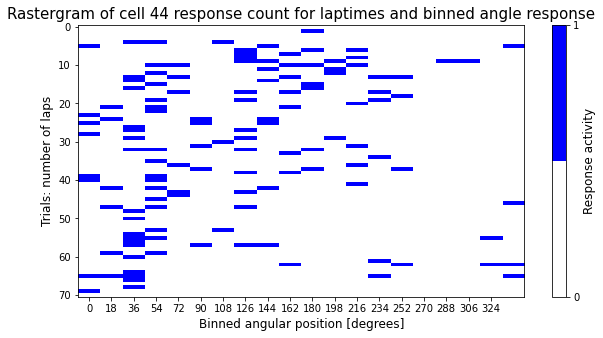

In [40]:
# Creating new train with threshold at 20
train2 = eventtrain_fct(dFonF,20)

#  Function to binarise response
def binarised(resp,thresh):
    binary_response = np.zeros(resp.shape)
    for i in range(resp.shape[0]): # for each row
         for j in range(resp.shape[1]): # for each column
            if resp[i][j] >= thresh:
                binary_response[i][j] = 1
    return binary_response

# Discretising into binary colour map
cmap = ListedColormap(["None", "blue"]) 

# Plots of first three cells
list = [43]
for i in list:
    train_cell = train2[i,:]
    response,lap = get_lapresponse(sp=train_cell, phi_bin=phi_bin, nlaps=nlaps, nphi=edges.size)
    bin_resp = binarised(response,1)
    
    plt.figure(1+i, figsize=(10,5))
    plt.imshow(bin_resp,cmap=cmap,aspect='auto')
    plt.title(f'Rastergram of cell {i+1} response count for laptimes and binned angle response', fontsize=15)
    plt.xlabel('Binned angular position [degrees]', fontsize=12)
    plt.ylabel('Trials: number of laps', fontsize=12)
    
    cbar = plt.colorbar(ticks=[0,1])
    cbar.ax.set_yticklabels(['0','1'])
    cbar.ax.set_ylabel('Response activity', fontsize=12)
    ticks = np.arange(0,19)
    ticklabel = ['0','18', '36', '54', '72','90','108','126','144','162','180','198','216', '234','252','270','288','306','324','342','360']
    plt.xticks(np.arange(0,19), labels=ticklabel, fontsize=10)
    plt.yticks(np.arange(0,71,10), fontsize=10)